In [10]:
import pandas as pd
import numpy as np
import networkx as nx

# Load data
df = pd.read_csv(r"/Users/marclambertes/Python/Matches/Men/2024-2025/Eredivisie/AZ 2-1 Ajax.csv")

# Filter the data for one team
OneTeam = df.loc[(df['contestantId'] == 'd0zdg647gvgc95xdtk1vpbkys')].reset_index()

# Create a new column for time in seconds
OneTeam["newsecond"] = 60 * OneTeam["timeMin"] + OneTeam["timeSec"]
OneTeam.sort_values(by=['newsecond'], inplace=True)

# Identify the passer and recipient
OneTeam['passer'] = OneTeam['playerName']
OneTeam['recipient'] = OneTeam['passer'].shift(-1)

# Filter for only passes and then successful passes
Passes = OneTeam.loc[(OneTeam['typeId'] == 1)]
Completions = Passes.loc[(Passes['outcome'] == 1)]

# Find the time of the team's first substitution and filter passes before that
Subs = OneTeam.loc[(OneTeam['typeId'] == 18)]
SubTimes = Subs["newsecond"]
SubOne = SubTimes.min()

# Filter completions before the first substitution
Completions = Completions.loc[Completions['newsecond'] < SubOne]

# Calculate average locations and count of passes
average_locs_and_count = Completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean', 'count']})
average_locs_and_count.columns = ['x', 'y', 'count']

# Calculate passes between players
passes_between = Completions.groupby(['passer', 'recipient']).id.count().reset_index()
passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)
passes_between = passes_between.merge(average_locs_and_count, left_on='passer', right_index=True)
passes_between = passes_between.merge(average_locs_and_count, left_on='recipient', right_index=True, suffixes=['', '_end'])

# Set a minimum threshold for pass arrows to be plotted
passes_between = passes_between.loc[(passes_between['pass_count'] > 2)]

# Build a directed graph from passes_between data
G = nx.DiGraph()

# Add edges with weights (pass counts)
for _, row in passes_between.iterrows():
    G.add_edge(row['passer'], row['recipient'], weight=row['pass_count'])

# Calculate Network Metrics
in_degree = dict(G.in_degree(weight='weight'))
out_degree = dict(G.out_degree(weight='weight'))
betweenness = nx.betweenness_centrality(G, weight='weight', normalized=True)
closeness = nx.closeness_centrality(G)
eigenvector = nx.eigenvector_centrality_numpy(G, weight='weight')
clustering = nx.clustering(G.to_undirected(), weight='weight')
reciprocity = nx.reciprocity(G)
assortativity = nx.degree_assortativity_coefficient(G, weight='weight')

density = nx.density(G)
if nx.is_strongly_connected(G):
    avg_path_length = nx.average_shortest_path_length(G, weight='weight')
else:
    avg_path_length = None  # Only valid for strongly connected networks

# Combine metrics into a DataFrame
metrics = pd.DataFrame({
    'In-Degree': in_degree,
    'Out-Degree': out_degree,
    'Betweenness': betweenness,
    'Closeness': closeness,
    'Eigenvector': eigenvector,
    'Clustering': clustering
}).fillna(0)
metrics = metrics.sort_values(by='Betweenness', ascending=False)

# Output global metrics
print("Global Metrics:")
print(f"Network Density: {density:.4f}")
print(f"Network Reciprocity: {reciprocity:.4f}")
print(f"Network Assortativity: {assortativity:.4f}")
if avg_path_length is not None:
    print(f"Average Path Length: {avg_path_length:.4f}")

print("\nPlayer-Level Metrics:")
print(metrics)

# Save metrics to a CSV
metrics.to_csv('pass_network_metrics2.csv', index=True)


Global Metrics:
Network Density: 0.3727
Network Reciprocity: 0.7805
Network Assortativity: -0.0483

Player-Level Metrics:
                   In-Degree  Out-Degree  Betweenness  Closeness  Eigenvector  \
B. van den Boomen         24          34     0.296296   0.581818     0.299266   
J. Hato                   23          26     0.131481   0.492308     0.266832   
S. Berghuis               16          12     0.122222   0.492308     0.144472   
Y. Baas                   56          59     0.105556   0.640000     0.561288   
A. Gaaei                  21          19     0.066667   0.492308     0.216022   
R. Pasveer                31          34     0.055556   0.581818     0.373406   
K. Taylor                 15          18     0.055556   0.400000     0.216818   
C. Akpom                   9           3     0.033333   0.457143     0.109363   
J. Šutalo                 44          48     0.000000   0.581818     0.502641   
W. Weghorst                7           0     0.000000   0.450000    

In [5]:
import pandas as pd
import numpy as np
import networkx as nx
import os

def calculate_network_metrics(df, contestantId):
    # Filter the data for the specific team
    OneTeam = df.loc[df['contestantId'] == contestantId].reset_index()

    # Create a new column for time in seconds
    OneTeam["newsecond"] = 60 * OneTeam["timeMin"] + OneTeam["timeSec"]
    OneTeam.sort_values(by=['newsecond'], inplace=True)

    # Identify the passer and recipient
    OneTeam['passer'] = OneTeam['playerName']
    OneTeam['recipient'] = OneTeam['passer'].shift(-1)

    # Filter for only passes and then successful passes
    Passes = OneTeam.loc[(OneTeam['typeId'] == 1)]
    Completions = Passes.loc[(Passes['outcome'] == 1)]

    # Find the time of the team's first substitution and filter passes before that
    Subs = OneTeam.loc[(OneTeam['typeId'] == 18)]
    SubTimes = Subs["newsecond"]
    SubOne = SubTimes.min()

    # Filter completions before the first substitution
    Completions = Completions.loc[Completions['newsecond'] < SubOne]

    # Calculate average locations and count of passes
    average_locs_and_count = Completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean', 'count']})
    average_locs_and_count.columns = ['x', 'y', 'count']

    # Calculate passes between players
    passes_between = Completions.groupby(['passer', 'recipient']).id.count().reset_index()
    passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)
    passes_between = passes_between.merge(average_locs_and_count, left_on='passer', right_index=True)
    passes_between = passes_between.merge(average_locs_and_count, left_on='recipient', right_index=True, suffixes=['', '_end'])

    # Set a minimum threshold for pass arrows to be plotted
    passes_between = passes_between.loc[(passes_between['pass_count'] > 2)]

    # Build a directed graph from passes_between data
    G = nx.DiGraph()

    # Add edges with weights (pass counts)
    for _, row in passes_between.iterrows():
        G.add_edge(row['passer'], row['recipient'], weight=row['pass_count'])

    # If the graph is empty, return an empty DataFrame
    if G.number_of_nodes() == 0:
        print(f"No passes found for team {contestantId}. Skipping.")
        return pd.DataFrame()

    # Calculate Network Metrics
    in_degree = dict(G.in_degree(weight='weight'))
    out_degree = dict(G.out_degree(weight='weight'))
    betweenness = nx.betweenness_centrality(G, weight='weight', normalized=True)
    closeness = nx.closeness_centrality(G)
    eigenvector = nx.eigenvector_centrality_numpy(G, weight='weight')
    clustering = nx.clustering(G.to_undirected(), weight='weight')
    reciprocity = nx.reciprocity(G)
    assortativity = nx.degree_assortativity_coefficient(G, weight='weight')

    density = nx.density(G)
    if nx.is_strongly_connected(G):
        avg_path_length = nx.average_shortest_path_length(G, weight='weight')
    else:
        avg_path_length = None  # Only valid for strongly connected networks

    # Combine metrics into a DataFrame
    metrics = pd.DataFrame({
        'In-Degree': in_degree,
        'Out-Degree': out_degree,
        'Betweenness': betweenness,
        'Closeness': closeness,
        'Eigenvector': eigenvector,
        'Clustering': clustering
    }).fillna(0)
    metrics['Density'] = density
    metrics['Reciprocity'] = reciprocity
    metrics['Assortativity'] = assortativity
    if avg_path_length is not None:
        metrics['Avg Path Length'] = avg_path_length

    return metrics

# Directory with CSV files
csv_folder = r"/Users/marclambertes/Python/Matches/Men/2024-2025/Eredivisie/"

# Initialize an empty DataFrame to store all players' metrics
all_player_metrics = pd.DataFrame()

# Loop through all CSV files in the folder
for csv_file in os.listdir(csv_folder):
    if csv_file.endswith(".csv"):
        file_path = os.path.join(csv_folder, csv_file)
        df = pd.read_csv(file_path)
        
        # Get all unique teams (contestantId)
        unique_teams = df['contestantId'].unique()
        
        # Process each team individually
        for team_id in unique_teams:
            metrics = calculate_network_metrics(df, team_id)
            
            # Append the metrics to the all_player_metrics DataFrame
            all_player_metrics = pd.concat([all_player_metrics, metrics], axis=0)

# Calculate the average of the metrics for each player
average_metrics = all_player_metrics.groupby(all_player_metrics.index).mean()

# Save the averaged metrics to a CSV
average_metrics.to_excel('average_player_metrics.xlsx', index=True)

print("Averaged player metrics saved to 'average_player_metrics.csv'.")


No passes found for team 1fttb31hnskynpku8qd09yhm8. Skipping.
No passes found for team 59t7flioj4w4mpwnrwbm0m8ck. Skipping.
No passes found for team b79uipsy57y1jqpy07h4i5ovk. Skipping.


/Users/marclambertes/anaconda3/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


No passes found for team 8iawijq7s9s6d85mjz8wdslki. Skipping.
No passes found for team 3kfktv64h7kg7zryax1wktr5r. Skipping.
Averaged player metrics saved to 'average_player_metrics.csv'.


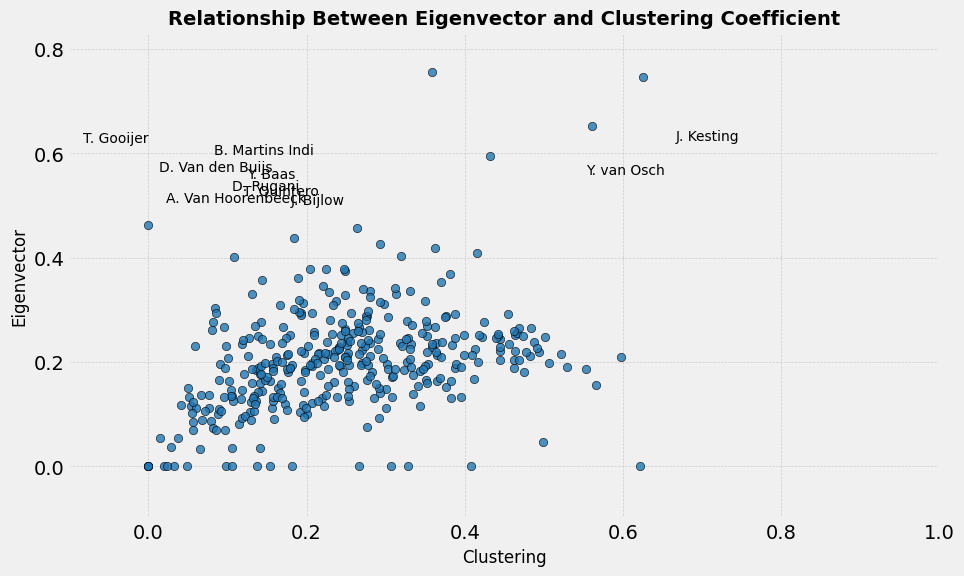

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the averaged metrics data
average_metrics = pd.read_csv('average_player_metrics.csv', index_col=0)

# Extract the relevant metrics
x = average_metrics['Eigenvector']  # Use 'Closeness' as a proxy for openness
y = average_metrics['Clustering']

# Set the FiveThirtyEight style
plt.style.use('fivethirtyeight')

# Create the scatterplot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, color="#1f77b4", alpha=0.8, edgecolor="black")

# Add annotations for key points if needed
# Here, as an example, we're labeling the top 5 players by Betweenness
top_players = average_metrics.sort_values(by='Eigenvector', ascending=False).head(10)
for player, row in top_players.iterrows():
    plt.text(row['Clustering'], row['Eigenvector'], player, fontsize=10, ha='right', color='black')

# Add labels, title, and gridlines
plt.title("Relationship Between Eigenvector and Clustering Coefficient", fontsize=14, weight='bold')
plt.xlabel("Clustering", fontsize=12)
plt.ylabel("Eigenvector", fontsize=12)
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)

# Adjust axis limits for aesthetics
plt.xlim(-0.1, 1)  # Assuming closeness ranges from 0 to 1
plt.ylim(-0.1, max(y) * 1.1)

# Save the plot as a high-resolution PNG
plt.savefig("scatterplot_betweenness_openness.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


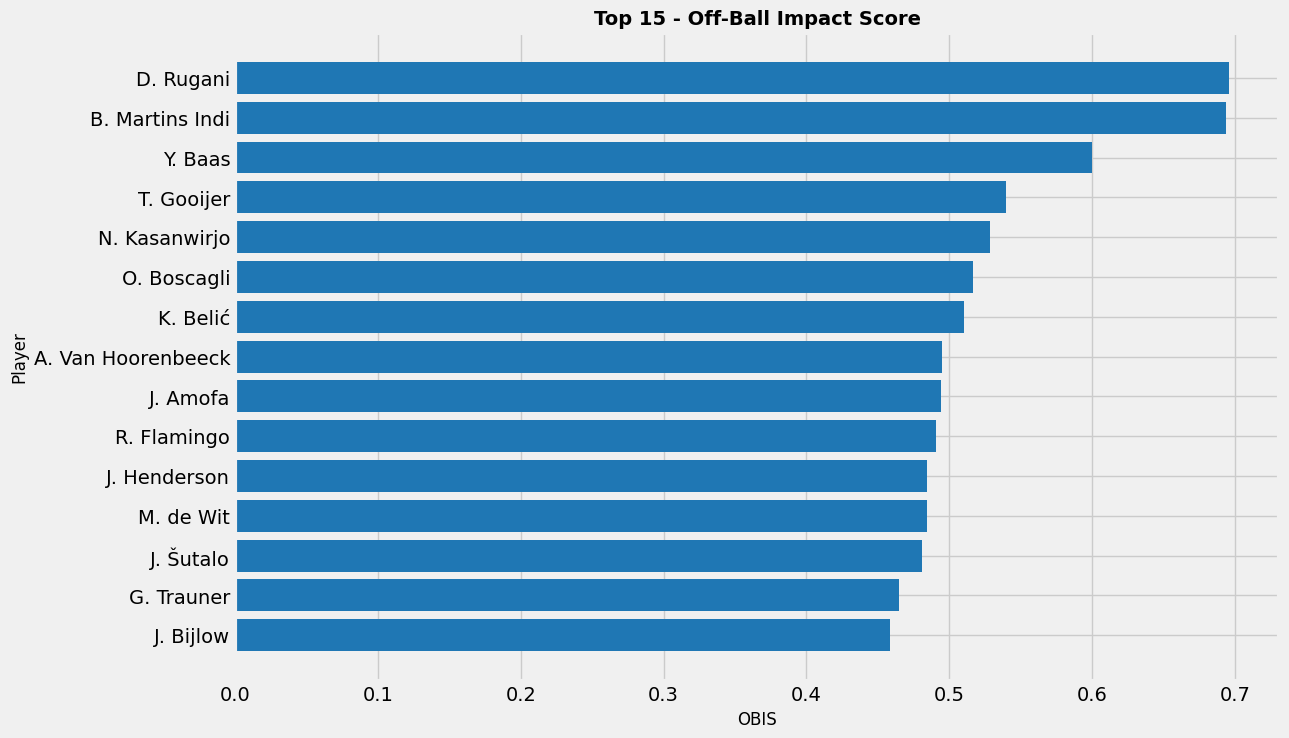

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load metrics data
metrics_df = pd.read_csv('average_player_metrics.csv', index_col=0)

# Normalize metrics (Min-Max Scaling)
metrics_df['Normalized In-Degree'] = (metrics_df['In-Degree'] - metrics_df['In-Degree'].min()) / (metrics_df['In-Degree'].max() - metrics_df['In-Degree'].min())
metrics_df['Normalized Betweenness'] = (metrics_df['Betweenness'] - metrics_df['Betweenness'].min()) / (metrics_df['Betweenness'].max() - metrics_df['Betweenness'].min())
metrics_df['Normalized Eigenvector'] = (metrics_df['Eigenvector'] - metrics_df['Eigenvector'].min()) / (metrics_df['Eigenvector'].max() - metrics_df['Eigenvector'].min())

# Define weights
w1 = 0.5  # Weight for In-Degree
w2 = 0.3  # Weight for Betweenness
w3 = 0.2  # Weight for Eigenvector

# Calculate Off-Ball Value
metrics_df['Off-Ball Value'] = (
    w1 * metrics_df['Normalized In-Degree'] +
    w2 * metrics_df['Normalized Betweenness'] +
    w3 * metrics_df['Normalized Eigenvector']
)

# Sort by Off-Ball Value
metrics_df.sort_values('Off-Ball Value', ascending=False, inplace=True)

# Save the updated DataFrame
metrics_df.to_csv('player_off_ball_value_with_eigenvector.csv', index=True)

# Create a bar chart for Off-Ball Value
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))

# Plot top 10 players
top_players = metrics_df.head(15)
plt.barh(top_players.index, top_players['Off-Ball Value'], color="#1f77b4")

# Add labels and title
plt.xlabel("OBIS", fontsize=12)
plt.ylabel("Player", fontsize=12)
plt.title("Top 15 - Off-Ball Impact Score", fontsize=14, weight='bold')

# Invert y-axis for aesthetics
plt.gca().invert_yaxis()

# Save the bar chart
plt.savefig("off_ball_value_chart_with_eigenvector.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


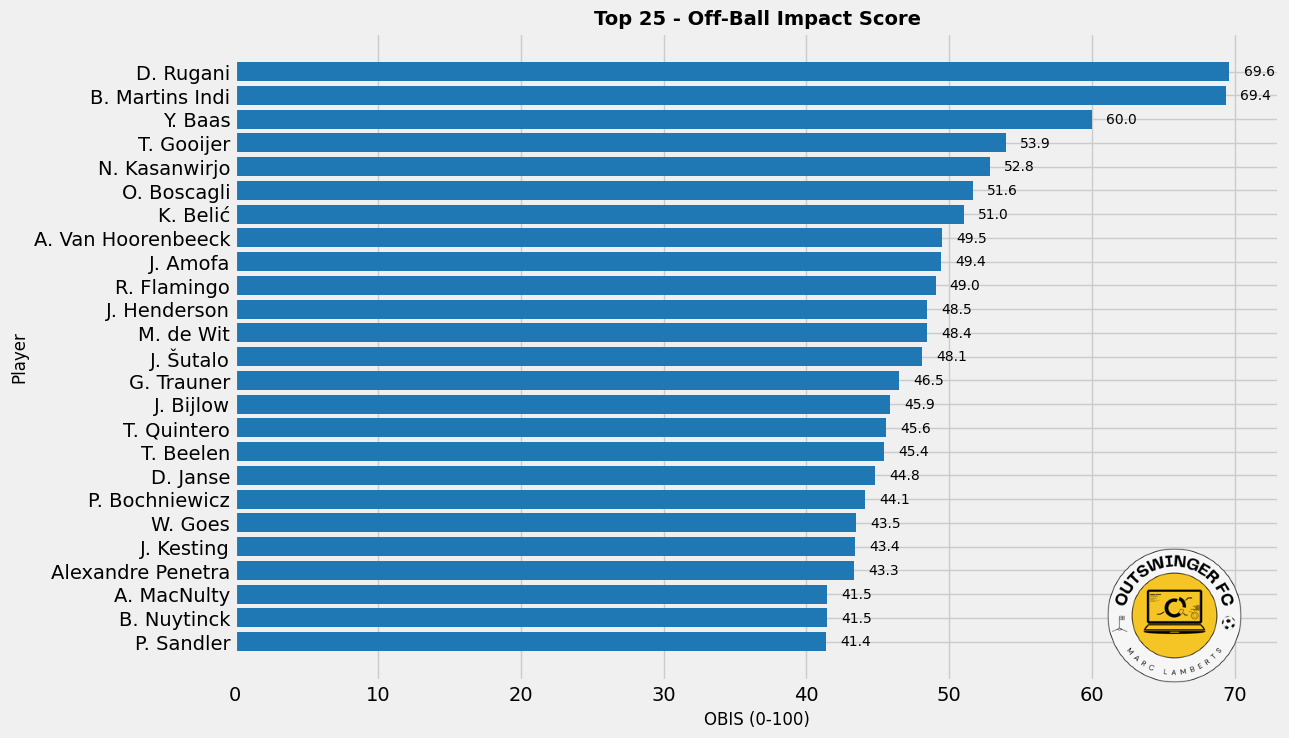

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Load metrics data
metrics_df = pd.read_csv('average_player_metrics.csv', index_col=0)

# Ensure the 'Eigenvector' column exists
if 'Eigenvector' in metrics_df.columns:
    # Normalize metrics (Min-Max Scaling)
    metrics_df['Normalized In-Degree'] = (metrics_df['In-Degree'] - metrics_df['In-Degree'].min()) / (metrics_df['In-Degree'].max() - metrics_df['In-Degree'].min())
    metrics_df['Normalized Betweenness'] = (metrics_df['Betweenness'] - metrics_df['Betweenness'].min()) / (metrics_df['Betweenness'].max() - metrics_df['Betweenness'].min())
    metrics_df['Normalized Eigenvector'] = (metrics_df['Eigenvector'] - metrics_df['Eigenvector'].min()) / (metrics_df['Eigenvector'].max() - metrics_df['Eigenvector'].min())

    # Define weights
    w1 = 0.5  # Weight for In-Degree
    w2 = 0.3  # Weight for Betweenness
    w3 = 0.2  # Weight for Eigenvector

    # Calculate Off-Ball Value
    metrics_df['Off-Ball Value'] = (
        w1 * metrics_df['Normalized In-Degree'] +
        w2 * metrics_df['Normalized Betweenness'] +
        w3 * metrics_df['Normalized Eigenvector']
    )

    # Scale metrics to a 0-100 range
    metrics_df['In-Degree (0-100)'] = metrics_df['Normalized In-Degree'] * 100
    metrics_df['Betweenness (0-100)'] = metrics_df['Normalized Betweenness'] * 100
    metrics_df['Eigenvector (0-100)'] = metrics_df['Normalized Eigenvector'] * 100
    metrics_df['Off-Ball Value (0-100)'] = metrics_df['Off-Ball Value'] * 100

    # Sort by Off-Ball Value
    metrics_df.sort_values('Off-Ball Value (0-100)', ascending=False, inplace=True)

    # Save the updated DataFrame
    metrics_df.to_csv('player_off_ball_value_scaled.csv', index=True)

    # Create a bar chart for Off-Ball Value
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(12, 8))

    # Plot top 25 players
    top_players = metrics_df.head(25)
    bars = plt.barh(top_players.index, top_players['Off-Ball Value (0-100)'], color="#1f77b4")

    # Add labels next to each bar
    for bar in bars:
        plt.text(
            bar.get_width() + 1,  # Position the label just outside the bar
            bar.get_y() + bar.get_height() / 2,  # Vertically center the label
            f"{bar.get_width():.1f}",  # Format the label to one decimal place
            va='center',  # Vertical alignment
            fontsize=10,  # Font size for the label
            color="black"  # Label color
        )

    # Add labels and title
    plt.xlabel("OBIS (0-100)", fontsize=12)
    plt.ylabel("Player", fontsize=12)
    plt.title("Top 25 - Off-Ball Impact Score", fontsize=14, weight='bold')

    # Invert y-axis for aesthetics
    plt.gca().invert_yaxis()

    # Add logo to the chart
    logo_path = "Outswinger FC (3).png"  # Path to your logo file
    logo_img = plt.imread(logo_path)
    imagebox = OffsetImage(logo_img, zoom=0.6)  # Adjust zoom as needed
    logo_box = AnnotationBbox(imagebox, (0.9, 0.1), xycoords='axes fraction', frameon=False)  # Bottom-right corner
    plt.gca().add_artist(logo_box)

    # Save the bar chart
    plt.savefig("off_ball_value_chart_with_logo.png", dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()
else:
    print("Error: The 'Eigenvector' column is missing from the data. Please check the input file.")
